# Racetrack Problem - Using MC Control to direct a car

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import pickle

In [5]:
# make a color map of fixed colors
track_col = "#F6EFC8"
car_col = "#3F4FE0"
bg_col = "#26261E"
start_col = "#D88680"
finish_col = "#6FAE6C"
cmap = mpc.ListedColormap([track_col, bg_col, start_col, finish_col, car_col])
bounds = [-1, 1, 2, 3, 4, 5]
norm = mpc.BoundaryNorm(bounds, cmap.N)

value_dict = {" ": 0, "*": 1, "S": 2, "F": 3, "C": 4}


def plot_track(
    track: np.ndarray,
    state: None | np.ndarray = None,
    t: None | int = None,
):
    # tell imshow about color map so that only set colors are used
    track_plot = track.copy()
    if state is not None:
        track_plot[state[0], state[1]] = value_dict["C"]
    plt.imshow(
        track_plot, interpolation="nearest", cmap=cmap, norm=norm, origin="lower"
    )
    if t is not None:
        plt.title(f"Time step: {t}")
    plt.axis("off")

    # set the limits of the axes to include the area where the text will be displayed
    plt.xlim([-1, track.shape[1] + 1])
    plt.ylim([-1, track.shape[0] + 1])

    # alongside the image, add text showing the 4 state components: y, x, v_y, v_x
    if state is not None:
        state_names = ["$y$", "$x$", "$v_y$", "$v_x$"]
        state_str = "\n".join([f"{name}: {s}" for name, s in zip(state_names, state)])
        plt.text(
            track.shape[1] + 3,
            track.shape[0] / 2,
            state_str,
            color="black",
            fontsize=12,
        )

    plt.show()

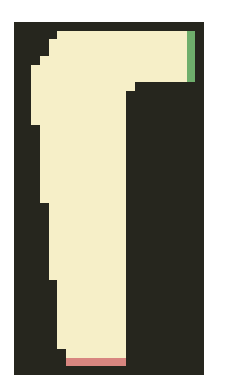

In [6]:
grid_file = "track1.txt"

track = None
with open(grid_file, "r") as f:
    start_grid = np.array(
        [[value_dict[c] for c in line.strip()] for line in f.readlines()]
    )
    start_grid = np.flip(start_grid, axis=0)

x_bounds = (0, start_grid.shape[1] - 1)
y_bounds = (0, start_grid.shape[0] - 1)

finish_x = np.where(start_grid == value_dict["F"])[1][0]
finish_y_min = np.where(start_grid == value_dict["F"])[0][0]
finish_y_max = np.where(start_grid == value_dict["F"])[0][-1]


def init_track():
    return start_grid.copy()


track = init_track()
plot_track(track)

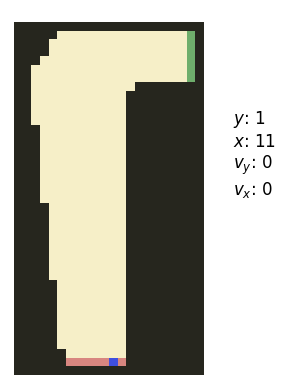

In [8]:
start_line_pos = np.array(np.where(track == value_dict["S"]))

track = init_track()


# let's get a random start position for the car
def init_state():
    y, x = start_line_pos[:, np.random.randint(start_line_pos.shape[1])]
    v_y, v_x = 0, 0
    return np.array((y, x, v_y, v_x))


def return_to_start():
    """doesn't reset the velocity, just the position"""
    global state
    y, x = start_line_pos[:, np.random.randint(start_line_pos.shape[1])]
    state[:2] = y, x


terminated = False
t = 0
state = init_state()
plot_track(track, state)

In [10]:
from IPython import display
import time


# Time to try moving the car - let's set it's v_y to 1 (which will counterintuitively need to move it down)
def update_state():
    global state
    global terminated
    global t
    t += 1
    y, x, v_y, v_x = state
    state[0] = np.clip(state[0] + v_y, a_min=y_bounds[0], a_max=y_bounds[1])
    state[1] = np.clip(state[1] + v_x, a_min=x_bounds[0], a_max=x_bounds[1])

    new_loc = track[state[0], state[1]]

    # check if finished
    if new_loc == value_dict["F"]:
        # print("Finished!")
        terminated = True
        return

    # check if gone out of bounds
    if new_loc == value_dict["*"]:
        # If we intersected with the finish line, we're done.
        passed_finish_x = state[1] >= finish_x
        passed_finish_y = state[0] >= finish_y_min and state[0] <= finish_y_max
        if passed_finish_x and passed_finish_y:
            # print("Finished!")
            terminated = True
        else:
            # return the car to the start line and remove it's velocity
            state[2:] = 0, 0
            return_to_start()


# we want a 3x3 grid of actions - each item is a tuple of (dv_y, dv_x)
# fmt: off
A = np.array([
    (-1, -1), (-1, 0), (-1, 1),
    ( 0, -1), ( 0, 0), ( 0, 1),
    ( 1, -1), ( 1, 0), ( 1, 1)
])
# fmt: on
dv_y, dv_x = A[0]


def fast_simulate_episode(
    policy: np.ndarray,
    max_steps: int = 500,
    noise_prob=0.1,
    eps=0.05,
) -> None:
    global state
    global terminated
    global t
    state = init_state()
    terminated = False
    t = 0
    states_hist = []
    actions_hist = []
    while not terminated:
        # select an action - epsilon greedy
        if np.random.rand() < eps:
            a = np.random.randint(len(A))
        else:
            a = policy[tuple(state)]
        actions_hist.append(a)
        states_hist.append(state.copy())

        # there is a 10% chance that no action is taken
        if np.random.rand() < noise_prob:
            dv_y, dv_x = 0, 0
        else:
            dv_y, dv_x = A[a]

        # Apply the action and update the state
        state[2] = np.clip(state[2] + dv_y, a_min=0, a_max=4)
        state[3] = np.clip(state[3] + dv_x, a_min=0, a_max=4)
        update_state()
        if t > max_steps:
            break
    return terminated, np.array(states_hist), np.array(actions_hist)

In [11]:
# to initialise the value function, we'll need to know the full size of the state-space
# this means every possible in-bounds value of x,y and all possible velocities (0 to 4 in each x and y), and all possible actions (9)
possible_states = (track.shape[0], track.shape[1], 5, 5, 9)
C = np.zeros(possible_states)
Q = np.random.rand(*possible_states) - 35
pi = np.argmax(Q, axis=-1)
gamma = 0.9
num_episodes = 50_000_000
finished_count = 0
terminated = False
G_hist = []
eps = 0.05
# setup for early stopping
pi_last = pi.copy()

for i in range(num_episodes):
    terminated, states_hist, actions_hist = fast_simulate_episode(
        policy=pi, max_steps=500, noise_prob=0.1, eps=eps
    )
    if i % 1_000_000 == 0:
        if (pi == pi_last).all() and i > 0:
            print(f"Early stopping")
            break
        pi_last = pi.copy()
        print(f"Episode {i:>7,} - Finished: {finished_count:>7,}/{i:,}")

    if not terminated:
        continue

    G = 0
    W = 1
    finished_count += 1
    T = len(states_hist)
    for t in range(T - 1, -1, -1):
        if t == T - 1:
            G = 0
        else:
            G = gamma * G - 1
        G_hist.append(G)
        S_t = tuple(states_hist[t])
        A_t = actions_hist[t]
        S_t_A_t = S_t + (A_t,)  # concatenate the state and action to get the index
        C[S_t_A_t] += W
        Q[S_t_A_t] += W / C[S_t_A_t] * (G - Q[S_t_A_t])
        pi[S_t] = np.argmax(Q[S_t])
        if A_t != pi[S_t]:
            break
        W = W * (1 - eps + eps / len(A))

print(f"Episode {i:>7,} - Finished: {finished_count:>7,}/{i:,}")

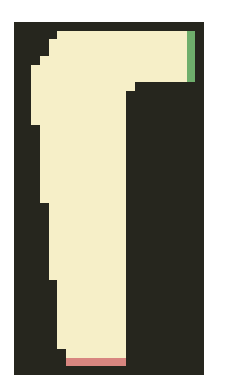

In [38]:
plot_track(track)

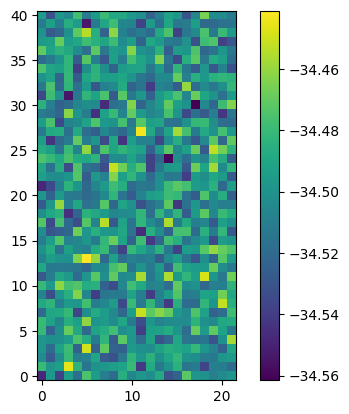

In [12]:
plt.imshow(Q.mean(axis=(2, 3, 4)), origin="lower")
plt.colorbar()

In [20]:
def vis_simulate_episode(
    policy: np.ndarray,
    max_steps: int = 500,
    noise_prob=0.1,
    eps=0.05,
    render_time: float = 0.1,
    start_pos: tuple[int, int] | None = None,
) -> None:
    global state
    global terminated
    global t
    state = init_state()
    if start_pos is not None:
        state[:2] = start_pos
    terminated = False
    t = 0
    states_hist = []
    actions_hist = []
    while not terminated:
        # select an action - epsilon greedy
        if np.random.rand() < eps:
            a = np.random.randint(len(A))
        else:
            a = policy[tuple(state)]
        actions_hist.append(a)
        states_hist.append(state.copy())

        # there is a 10% chance that no action is taken
        if np.random.rand() < noise_prob:
            dv_y, dv_x = 0, 0
        else:
            dv_y, dv_x = A[a]

        # Apply the action and update the state
        state[2] = np.clip(state[2] + dv_y, a_min=0, a_max=4)
        state[3] = np.clip(state[3] + dv_x, a_min=0, a_max=4)
        update_state()
        if t > max_steps:
            break
        plot_track(track, state, t)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(render_time)
    plot_track(track, state, t)
    return terminated, np.array(states_hist), np.array(actions_hist)


def vis_simulate_random_episode(
    policy: np.ndarray,
    max_steps: int = 500,
    noise_prob=0.1,
    eps=0.05,
    render_time: float = 0.1,
    start_pos: tuple[int, int] | None = None,
) -> None:
    global state
    global terminated
    global t
    state = init_state()
    if start_pos is not None:
        state[:2] = start_pos
    terminated = False
    t = 0
    states_hist = []
    actions_hist = []
    while not terminated:
        # select an action - epsilon greedy
        a = np.random.randint(len(A))
        actions_hist.append(a)
        states_hist.append(state.copy())

        # there is a 10% chance that no action is taken
        if np.random.rand() < noise_prob:
            dv_y, dv_x = 0, 0
        else:
            dv_y, dv_x = A[a]

        # Apply the action and update the state
        state[2] = np.clip(state[2] + dv_y, a_min=0, a_max=4)
        state[3] = np.clip(state[3] + dv_x, a_min=0, a_max=4)
        update_state()
        if t > max_steps:
            break
        plot_track(track, state, t)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(render_time)
    plot_track(track, state, t)
    return terminated, np.array(states_hist), np.array(actions_hist)

In [51]:
with open("Q_trained.pkl", "wb") as f:
    pickle.dump(Q, f)

with open("pi_trained.pkl", "wb") as f:
    pickle.dump(pi, f)

In [27]:
with open("pi_trained.pkl", "rb") as f:
    pi = pickle.load(f)

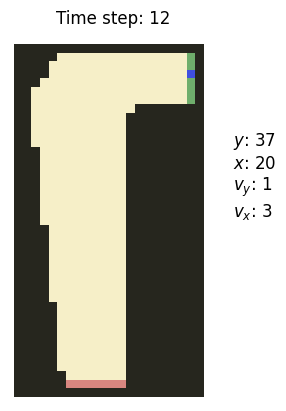

KeyboardInterrupt: 

In [31]:
for i in range(5):
    _ = vis_simulate_episode(pi, render_time=0.1, noise_prob=0.0, eps=0.0)

In [26]:
_ = vis_simulate_random_episode(
    pi, render_time=0.1, noise_prob=0.0, eps=0.0, start_pos=(1, 11)
)

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [30]:
start_line_pos

array([[ 1,  1,  1,  1,  1,  1,  1],
       [ 6,  7,  8,  9, 10, 11, 12]])

In [53]:
A[pi[1, 12, 0, 0]]

array([-1,  1])